<a href="https://colab.research.google.com/github/rosinys/CarDataAnalysis/blob/main/CarSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🚗 Car Sales Data Analysis**

### 📁 Read Data




In [ ]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("anjaliprajapati307/usa-car-sales-dataset-2018-2024")

print("Path to dataset files:", path)

# Find the CSV file in the downloaded folder
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = os.path.join(path, file)
        break

# Read the dataset
car_sales_df = pd.read_csv(csv_file)


100%|██████████| 45.3M/45.3M [00:00<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anjaliprajapati307/usa-car-sales-dataset-2018-2024/versions/1


### 🔍Data Analysis

In [ ]:
car_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000668 entries, 0 to 1000667
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Date               1000668 non-null  object 
 1   Salesperson        1000668 non-null  object 
 2   Customer Name      1000668 non-null  object 
 3   Customer Age       1000668 non-null  int64  
 4   Customer Gender    1000668 non-null  object 
 5   Car Make           1000668 non-null  object 
 6   Car Model          1000668 non-null  object 
 7   Car Year           1000668 non-null  int64  
 8   Quantity           1000668 non-null  int64  
 9   Sale Price         1000668 non-null  float64
 10  Cost               1000668 non-null  float64
 11  Profit             1000668 non-null  float64
 12  Discount           1000668 non-null  float64
 13  Payment Method     1000668 non-null  object 
 14  Commission Rate    1000668 non-null  float64
 15  Commission Earned  1000668 non-n

In [ ]:
unique_makes = sorted(car_sales_df['Car Make'].dropna().unique())
print("Number of unique car makes:", len(unique_makes))
print(unique_makes)

Number of unique car makes: 10
['Audi', 'BMW', 'Chevrolet', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mercedes', 'Nissan', 'Toyota']


In [ ]:
car_sales_df.duplicated().sum()

np.int64(0)

In [ ]:
# Find the duplicate groups based on Date, Salesperson, Customer Name
duplicate_mask = car_sales_df.duplicated(subset=['Date', 'Salesperson', 'Customer Name'], keep=False)

# Remove duplicate rows
car_sales_df_cleaned = car_sales_df[~duplicate_mask].copy()

# Verify
print(f"Original rows: {len(car_sales_df)}")
print(f"Rows after removing duplicate groups: {len(car_sales_df_cleaned)}")


Original rows: 1000668
Rows after removing duplicate groups: 1000526


In [ ]:
# Convert the 'Date' column to datetime format (YYYY-MM-DD)
car_sales_df['Date'] = pd.to_datetime(car_sales_df['Date'], format='%Y-%m-%d', errors='coerce')
print(car_sales_df['Date'].dtype)

datetime64[ns]


In [ ]:
# Drop the given data
cols_to_drop = ['Sale Year', 'Sale Month', 'Sale Quarter', 'Day of Week']
car_sales_df = car_sales_df.drop(columns=[col for col in cols_to_drop if col in car_sales_df.columns])

In [ ]:
# Extract time-based features from the 'Date' column
car_sales_df['Sale Year'] = car_sales_df['Date'].dt.year          # numeric values
car_sales_df['Sale Month'] = car_sales_df['Date'].dt.month        # numeric values 1-12
car_sales_df['Sale Quarter'] = car_sales_df['Date'].dt.quarter    # numeric values 1-4
car_sales_df['Day of Week'] = car_sales_df['Date'].dt.day_name()  # numeric values 1-7

In [ ]:
# Convert categorical time features to numeric values for easier analysis

day_map = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
car_sales_df['Day of Week Num'] = car_sales_df['Day of Week'].map(day_map)

season_map = {'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4}
car_sales_df['Season Num'] = car_sales_df['Season'].map(season_map)  # if Season still exists

In [ ]:
# Standarize data to car based details
car_sales_df['Total Tag Price'] = car_sales_df['Sale Price'] / (1 - car_sales_df['Discount'])
car_sales_df['Car Tag Price'] = car_sales_df['Total Tag Price'] / car_sales_df['Quantity']
car_sales_df['Dealer Car Price'] = car_sales_df['Cost'] / car_sales_df['Quantity']
car_sales_df['Profit_per_Car'] = car_sales_df['Profit'] / car_sales_df['Quantity']
car_sales_df['Profit_Margin_per_Car'] = car_sales_df['Profit_per_Car'] / car_sales_df['Dealer Car Price']

In [ ]:
# Calculate Car Age
car_sales_df['Car Age'] = car_sales_df['Sale Year'] - car_sales_df['Car Year']

# check outcomes
print(car_sales_df[['Car Year', 'Sale Year', 'Car Age']].head())


   Car Year  Sale Year  Car Age
0      2019       2019        0
1      2021       2018       -3
2      2023       2021       -2
3      2022       2020       -2
4      2019       2020        1


In [ ]:
## Remove rows with negative Car Age - negative 1 is still possible because new models are technically released the year before
# 2026 model is released during 2025
car_sales_df = car_sales_df[car_sales_df['Car Age'] >= -1].copy()

# Verify
print(f"Rows remaining after removing negative Car Age: {len(car_sales_df)}")
print(car_sales_df['Car Age'].describe())


Rows remaining after removing negative Car Age: 694488
count    694488.000000
mean          1.474044
std           1.944779
min          -1.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           6.000000
Name: Car Age, dtype: float64


In [ ]:
# Differentiate cars based on if it was an early release purchase (if was purchased right away)
car_sales_df['Early Release Purchase'] = car_sales_df['Car Age'] <= 0

# Replace negative Car Age with 0, since these are new cars
car_sales_df.loc[car_sales_df['Car Age'] < 0, 'Car Age'] = 0

# Verify
print(car_sales_df[['Car Year', 'Sale Year', 'Car Age', 'Early Release Purchase']].sample(10))


        Car Year  Sale Year  Car Age  Early Release Purchase
253241      2023       2023        0                    True
78520       2022       2022        0                    True
855489      2021       2021        0                    True
847741      2022       2024        2                   False
449561      2023       2023        0                    True
887751      2019       2021        2                   False
97944       2020       2021        1                   False
982760      2019       2018        0                    True
554025      2022       2024        2                   False
542837      2018       2024        6                   False


In [ ]:
# Look into dataframe's statistics
print(car_sales_df.describe())

                                Date   Customer Age       Car Year  \
count                         694488  694488.000000  694488.000000   
mean   2022-03-27 23:55:16.846943488      45.029668    2020.263129   
min              2018-01-01 00:00:00      20.000000    2018.000000   
25%              2020-11-17 00:00:00      32.000000    2019.000000   
50%              2022-07-03 00:00:00      45.000000    2020.000000   
75%              2023-10-15 00:00:00      58.000000    2022.000000   
max              2024-12-31 00:00:00      70.000000    2024.000000   
std                              NaN      14.725391       1.819110   

            Quantity    Sale Price          Cost        Profit       Discount  \
count  694488.000000  6.944880e+05  6.944880e+05  6.944880e+05  694488.000000   
mean        2.120912  8.656855e+04  7.254769e+04  1.402086e+04       0.059981   
min         1.000000  9.508000e+03  8.016360e+03 -1.499900e+07       0.000000   
25%         2.000000  5.495998e+04  4.363424e

### Winsorizing

In [ ]:
from scipy.stats import mstats

# Columns to Winsorize
cols_to_winsorize = [
    'Total Tag Price', 'Car Tag Price', 'Dealer Car Price',
    'Profit_per_Car', 'Profit_Margin_per_Car'
]

# Make a copy of your current dataset
car_sales_winsorized = car_sales_df.copy()

# Function to Winsorize per Car Model
def winsorize_group(df, group_col, target_col, lower_pct=0.01, upper_pct=0.01):
    """Winsorize a column per group based on percentiles"""
    def cap(group):
        return mstats.winsorize(group, limits=[lower_pct, upper_pct])
    return df.groupby(group_col)[target_col].transform(cap)

# Apply Winsorization per Car Model
for col in cols_to_winsorize:
    car_sales_winsorized[col] = winsorize_group(car_sales_winsorized, 'Car Model', col)

# Optional: check min/max after Winsorization
for col in cols_to_winsorize:
    print(f"{col}: min={car_sales_winsorized[col].min():,.2f}, max={car_sales_winsorized[col].max():,.2f}")


Total Tag Price: min=18,711.46, max=262,152.00
Car Tag Price: min=16,559.00, max=95,833.52
Dealer Car Price: min=12,237.24, max=78,130.58
Profit_per_Car: min=-7,990.91, max=26,045.52
Profit_Margin_per_Car: min=-0.11, max=0.43


### Eliminate Negative Profits

In [ ]:
# Count rows with negative Profit
negative_profit_count = car_sales_winsorized[car_sales_winsorized['Profit'] < 0].shape[0]

print(f"Number of rows with negative Profit: {negative_profit_count}")


Number of rows with negative Profit: 46919


In [ ]:
# Remove rows with negative profit
car_sales_cleaned = car_sales_winsorized[car_sales_winsorized['Profit'] >= 0].copy()

# Check new dataset size
print(f"Original rows: {car_sales_winsorized.shape[0]}")
print(f"Rows after removing negative profit: {car_sales_cleaned.shape[0]}")


Original rows: 694488
Rows after removing negative profit: 647569


### Outliers Investigation

In [ ]:
# Columns to check
cols_to_check = [
    'Sale Price', 'Cost', 'Profit',
    'Total Tag Price', 'Car Tag Price', 'Dealer Car Price',
    'Profit_per_Car', 'Profit_Margin_per_Car'
]

# Create a DataFrame indicating outliers per column
outlier_flags = pd.DataFrame(index=car_sales_cleaned.index)

for col in cols_to_check:
    Q1 = car_sales_cleaned[col].quantile(0.25)
    Q3 = car_sales_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    # True if row is an outlier in this column
    outlier_flags[col + '_outlier'] = ((car_sales_cleaned[col] < (Q1 - 1.5 * IQR)) |
                                       (car_sales_cleaned[col] > (Q3 + 1.5 * IQR)))

# Count how many rows are outliers in each column
print("Outlier counts per column:")
print(outlier_flags.sum())

# Count rows that are outliers in all columns
all_columns_outliers = outlier_flags.all(axis=1).sum()
print(f"\nNumber of rows that are outliers in all columns: {all_columns_outliers}")

# Count rows that are outliers in at least one column
at_least_one_outlier = outlier_flags.any(axis=1).sum()
print(f"Number of rows that are outliers in at least one column: {at_least_one_outlier}")


Outlier counts per column:
Sale Price_outlier               16657
Cost_outlier                     14572
Profit_outlier                   18489
Total Tag Price_outlier          16983
Car Tag Price_outlier             2361
Dealer Car Price_outlier          2720
Profit_per_Car_outlier            6145
Profit_Margin_per_Car_outlier        0
dtype: int64

Number of rows that are outliers in all columns: 0
Number of rows that are outliers in at least one column: 30628


In [ ]:
# Columns to check
cols_to_check = [
    'Sale Price', 'Cost', 'Profit',
    'Total Tag Price', 'Car Tag Price', 'Dealer Car Price',
    'Profit_per_Car', 'Profit_Margin_per_Car'
]

# Show the top 5 highest values for each column
for col in cols_to_check:
    top_values = car_sales_cleaned[col].sort_values(ascending=False).head(5)
    print(f"\nTop 5 highest values in {col}:")
    print(top_values)



Top 5 highest values in Sale Price:
278953    301902.51
1615      297589.11
425349    296947.56
447211    293417.67
723161    293180.16
Name: Sale Price, dtype: float64

Top 5 highest values in Cost:
447211    225228.52
1615      222518.11
105042    221270.26
278953    220089.36
436387    219994.78
Name: Cost, dtype: float64

Top 5 highest values in Profit:
425349    89084.27
363597    87261.99
450632    87109.66
794751    87034.31
393215    87013.02
Name: Profit, dtype: float64

Top 5 highest values in Total Tag Price:
508519    262152.0
307200    262152.0
340616    262152.0
60770     262152.0
562707    262152.0
Name: Total Tag Price, dtype: float64

Top 5 highest values in Car Tag Price:
278095    95833.516484
26836     95833.516484
633114    95833.516484
732889    95833.516484
775713    95833.516484
Name: Car Tag Price, dtype: float64

Top 5 highest values in Dealer Car Price:
15973     78130.583333
583121    78130.583333
938085    78003.580000
575454    77983.183333
173704    7795

In [ ]:
# Columns to show
cols_to_show = [
    'Car Make', 'Car Model', 'Car Age',
    'Sale Price', 'Cost', 'Profit',
    'Total Tag Price', 'Car Tag Price', 'Dealer Car Price',
    'Profit_per_Car', 'Profit_Margin_per_Car'
]

# For each numeric column, show the rows with the top 5 values
for col in ['Sale Price', 'Cost', 'Profit', 'Total Tag Price', 'Car Tag Price']:
    top_rows = car_sales_cleaned[cols_to_show].sort_values(by=col, ascending=False).head(5)
    print(f"\nTop 5 rows for {col}:")
    print(top_rows)



Top 5 rows for Sale Price:
        Car Make Car Model  Car Age  Sale Price       Cost    Profit  \
278953  Mercedes   S-Class        0   301902.51  220089.36  81813.15   
1615    Mercedes   S-Class        1   297589.11  222518.11  75071.00   
425349  Mercedes   C-Class        5   296947.56  207863.29  89084.27   
447211  Mercedes   E-Class        2   293417.67  225228.52  68189.15   
723161  Mercedes       GLE        0   293180.16  209146.83  84033.33   

        Total Tag Price  Car Tag Price  Dealer Car Price  Profit_per_Car  \
278953    262152.000000   95055.011765      73363.120000    26035.190000   
1615      262152.000000   95055.011765      74172.703333    25023.666667   
425349    261762.428571   95772.860215      69287.763333    25813.435000   
447211    260459.062500   95833.516484      75076.173333    22729.716667   
723161    259800.910112   94486.527473      69715.610000    25932.155000   

        Profit_Margin_per_Car  
278953               0.371727  
1615              

### Data Exploration

In [ ]:
car_sales_df.head(5)

,Date,Salesperson,Customer Name,Customer Age,Customer Gender,Car Make,Car Model,Car Year,Quantity,Sale Price,...,Day of Week,Day of Week Num,Season Num,Total Tag Price,Car Tag Price,Dealer Car Price,Profit_per_Car,Profit_Margin_per_Car,Car Age,Early Release Purchase
0,2019-04-02,Mary Simon,Kristin Blackwell,42,Male,Hyundai,Santa Fe,2019,1,25949.00,...,Tuesday,2,1,27314.736842,27314.736842,22137.550000,3811.450000,0.172171,0,True
4,2020-07-03,Brian Cline,Nicholas Fernandez,50,Male,Audi,A6,2019,1,48629.00,...,Friday,5,2,51732.978723,51732.978723,38186.630000,10442.370000,0.273456,1,False
6,2019-02-24,Rebekah Turner,Kenneth Jimenez,25,Female,Nissan,Pathfinder,2019,3,101629.71,...,Sunday,7,4,102656.272727,34218.757576,33213.503333,663.066667,0.019964,0,True
7,2024-02-12,Jessica Schaefer,Melissa Newman,23,Male,Ford,Escape,2020,2,98327.76,...,Monday,1,4,104604.000000,52302.000000,38774.625000,10389.255000,0.267940,4,False
9,2024-08-15,Christopher Scott,Susan Flores,56,Female,Hyundai,Tucson,2023,3,86658.39,...,Thursday,4,2,101951.047059,33983.682353,21759.583333,7126.546667,0.327513,1,False


In [ ]:
average_profit_margin = car_sales_cleaned['Profit_Margin_per_Car'].mean()
print(f"Average Profit Margin: {average_profit_margin:.2%}")

Average Profit Margin: 29.39%


In [ ]:
# Group by Car Model, calculate average profit margin, and sort from highest to lowest
avg_margin_per_model = car_sales_cleaned.groupby('Car Model')['Profit_Margin_per_Car'].mean()
avg_margin_per_model_sorted = avg_margin_per_model.sort_values(ascending=False)

# Format as percentage with 2 decimals
avg_margin_per_model_percent = avg_margin_per_model_sorted.apply(lambda x: f"{x:.2%}")

print(avg_margin_per_model_percent)

Car Model
C-Class       36.51%
E-Class       36.44%
S-Class       36.42%
GLE           36.36%
GLC           36.33%
7 Series      35.56%
3 Series      35.50%
X3            35.45%
X5            35.43%
5 Series      35.40%
A6            34.63%
A8            34.59%
Q7            34.58%
A4            34.57%
Q5            34.25%
Escape        28.19%
F-150         28.14%
Explorer      28.06%
Sportage      28.06%
Forte         27.97%
Sorento       27.94%
Telluride     27.91%
Mustang       27.91%
Optima        27.89%
Focus         27.84%
Tahoe         27.04%
Malibu        27.02%
Equinox       26.99%
Kona          26.98%
Elantra       26.97%
Tucson        26.97%
Santa Fe      26.93%
Silverado     26.86%
Camaro        26.79%
Sonata        26.75%
CR-V          26.11%
Maxima        26.02%
Pilot         26.01%
Rogue         25.99%
Pathfinder    25.99%
Odyssey       25.97%
Sentra        25.94%
Accord        25.91%
Altima        25.81%
Civic         25.79%
Prius         25.17%
Camry         25.17%
Cor

In [ ]:
# Group by Car Age and calculate average discount
avg_discount_per_age = car_sales_cleaned.groupby('Car Age')['Discount'].mean()

# Format as percentage with 2 decimals
avg_discount_per_age_percent = avg_discount_per_age.apply(lambda x: f"{x:.2%}")

print(avg_discount_per_age_percent)


Car Age
0    6.02%
1    6.03%
2    6.01%
3    6.00%
4    6.04%
5    5.99%
6    6.01%
Name: Discount, dtype: object


In [ ]:
car_sales_cleaned.groupby('Car Age')['Dealer Car Price'].count()

,Dealer Car Price
Car Age,
0,247075
1,114026
2,95434
3,76224
4,57566
5,38170
6,19074


In [ ]:
car_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647569 entries, 0 to 1000267
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    647569 non-null  datetime64[ns]
 1   Salesperson             647569 non-null  object        
 2   Customer Name           647569 non-null  object        
 3   Customer Age            647569 non-null  int64         
 4   Customer Gender         647569 non-null  object        
 5   Car Make                647569 non-null  object        
 6   Car Model               647569 non-null  object        
 7   Car Year                647569 non-null  int64         
 8   Quantity                647569 non-null  int64         
 9   Sale Price              647569 non-null  float64       
 10  Cost                    647569 non-null  float64       
 11  Profit                  647569 non-null  float64       
 12  Discount                647569 non

In [ ]:
# Count how many times each combination occurs
duplicate_counts = car_sales_cleaned.groupby(['Salesperson', 'Customer Name', 'Date']).size().reset_index(name='Count')

# Filter only those with Count > 1
duplicate_counts = duplicate_counts[duplicate_counts['Count'] > 1]

print(f"Number of duplicate combinations: {duplicate_counts.shape[0]}")
duplicate_counts.head()


Number of duplicate combinations: 36


,Salesperson,Customer Name,Date,Count
27706,Angela Brown,Chad Clark,2018-04-12,2
27771,Angela Brown,Charles Lawrence,2018-02-10,2
40856,Benjamin Beck,Chad Jacobs,2020-08-07,2
51471,Benjamin Beck,William Davis,2023-10-27,2
54969,Brian Cline,Deborah Wallace,2022-08-12,2


In [ ]:
# Merge the Quantity column for the duplicates
duplicates_with_qty = pd.merge(
    duplicate_counts,
    car_sales_cleaned[['Salesperson', 'Customer Name', 'Date', 'Quantity']],
    on=['Salesperson', 'Customer Name', 'Date'],
    how='left'
)

# Show the first few rows
duplicates_with_qty.head()


,Salesperson,Customer Name,Date,Count,Quantity
0,Angela Brown,Chad Clark,2018-04-12,2,2
1,Angela Brown,Chad Clark,2018-04-12,2,2
2,Angela Brown,Charles Lawrence,2018-02-10,2,2
3,Angela Brown,Charles Lawrence,2018-02-10,2,2
4,Benjamin Beck,Chad Jacobs,2020-08-07,2,1


In [ ]:
# Keep only rows that are NOT duplicates
car_sales_no_duplicates = car_sales_cleaned[~car_sales_cleaned.duplicated(subset=['Salesperson', 'Customer Name', 'Date'], keep=False)].copy()

# Check how many rows were removed
rows_removed = car_sales_cleaned.shape[0] - car_sales_no_duplicates.shape[0]
print(f"Number of rows removed: {rows_removed}")

# Check the new dataset size
print(f"New dataset size: {car_sales_no_duplicates.shape[0]} rows")


Number of rows removed: 72
New dataset size: 647497 rows


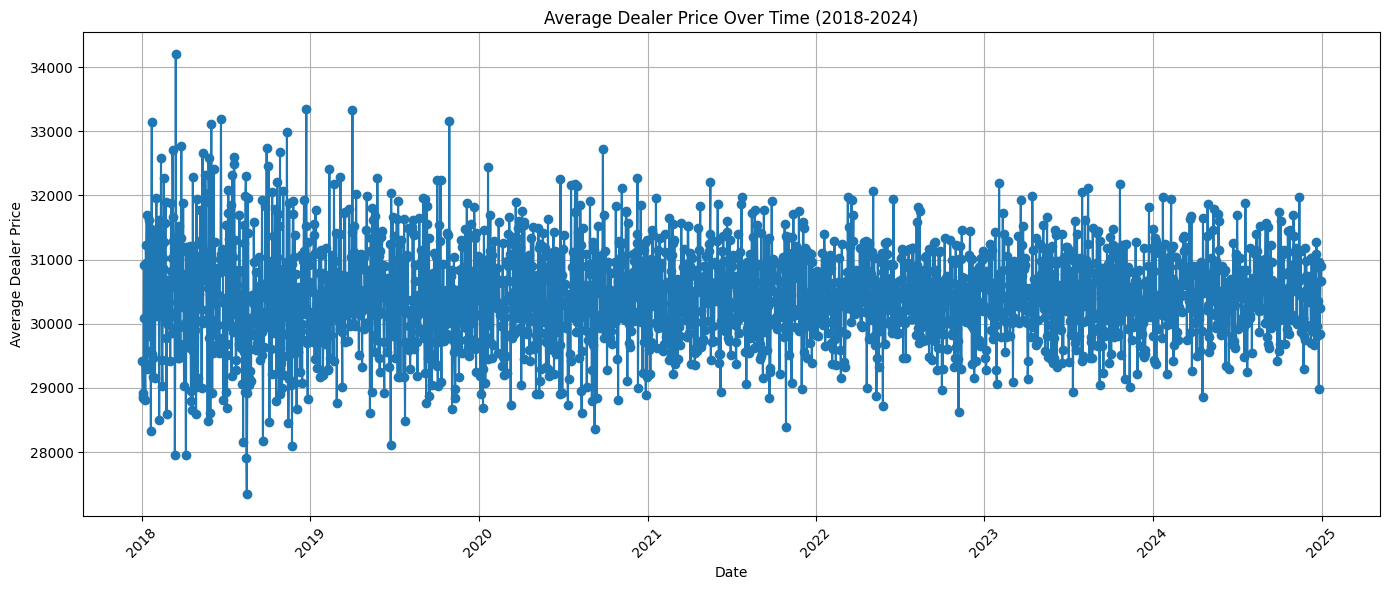

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'Date' is a datetime column
car_sales_no_duplicates['Date'] = pd.to_datetime(car_sales_no_duplicates['Date'])

# Filter data between 2018 and 2024
mask = (car_sales_no_duplicates['Date'].dt.year >= 2018) & (car_sales_no_duplicates['Date'].dt.year <= 2024)
df_filtered = car_sales_no_duplicates.loc[mask]

# Group by Date and calculate average Dealer Price
avg_dealer_price_by_date = df_filtered.groupby('Date')['Dealer Car Price'].mean().reset_index()

# Plot line chart
plt.figure(figsize=(14,6))
plt.plot(avg_dealer_price_by_date['Date'], avg_dealer_price_by_date['Dealer Car Price'], marker='o', linestyle='-')
plt.title('Average Dealer Price Over Time (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Average Dealer Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



### Download Data

In [ ]:
# Save the cleaned dataset to CSV
car_sales_no_duplicates.to_csv('/content/car_sales_no_duplicates.csv', index=False)

# Download the CSV to your computer
from google.colab import files
files.download('/content/car_sales_no_duplicates.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>